In [1]:
#############################################################################
################### Working version 2-10-2018 ###############################
#############################################################################

import numpy as np
import pandas as pd
from pyomo.environ import *
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import colorlover as cl
from plotly import tools
import plotly.offline as py
import os

from IPython.display import HTML

init_notebook_mode(connected=True)

############################ Settings #####################################

# setting up desirable levels [low, high] (fraction)
desirable_levels = [0.7, 0.8]

# Setting Switch and Level Weights
switch_weight = 1
level_weight = 100 
# maxlevel_weight = 100 

# Setting time horizon
number_of_periods = 20

###########################################################################


# Reading in data 
path = 'CorrectInputData/InputData/CSVs/'                                                            
transfer_matrix_file = 'TransferMatrixSCENARIOS.csv'
reservoir_capacities_file = 'ReservoirCapacities.csv'
start_level_file = 'StartLevel.csv'
treatment_outputs_file = 'TreatmentOutputs_Summer_Daily.csv'
demand_file_path = 'Demand_Summer.xlsx'
time_list = np.arange(1, number_of_periods+1, 1)

# competing_pumps_file = path+'CompetingPumps.csv'

#reading in csvs and setting index
transfer_matrix = pd.read_csv(transfer_matrix_file)
transfer_matrix.set_index(transfer_matrix.columns[0],inplace=True)
reservoir_capacities = pd.read_csv(reservoir_capacities_file)
reservoir_capacities.set_index(reservoir_capacities.columns[0],inplace=True)
softlow_level = desirable_levels[0]*reservoir_capacities
softmax_level = desirable_levels[1]*reservoir_capacities
hardlow_level = 0.01*reservoir_capacities
hardmax_level = reservoir_capacities
start_level = pd.read_csv(start_level_file)
start_level.set_index(start_level.columns[0],inplace=True)
treatment_outputs = pd.read_csv(treatment_outputs_file)
treatment_outputs.set_index(treatment_outputs.columns[0],inplace=True)

FileNotFoundError: File b'CorrectInputData/InputData/CSVs/ReservoirCapacities.csv' does not exist

In [2]:
# Defining treatment works and service reservoirs 
all_nodes = transfer_matrix.index.values
TW_amount = 8 # amount of treatment works
treatment_works = all_nodes[:TW_amount]
service_reservoirs = all_nodes[TW_amount:]
connection_list_check = []
connection_list = []
discr_pump_rate_dict = dict()
var_pump_max_output_dict = dict()

# # create lists of disc/var pumps

disc_pump_list = []
var_pump_list = []
comp_pumps_list =[]

for i in transfer_matrix.columns:
    for j in transfer_matrix.columns:
        if "|" in str(transfer_matrix[i][j]): 
            connection_list.append(f"{i}")
            connection_list.append(f"{j}")   
            connection_list_check.append(f"{i} {j}")
            # Read from transfer matrix per entry 0/1,value where 0/1 indicates
            # if a discrete pump is used, and value either the discrete pump rate 
            # or if variable speed pump the maximum pump flow 
            discr_pump, pump_value = transfer_matrix[i][j].split("|")
            if discr_pump == "1": 
                discr_pump_rate_dict[(i,j)] = float(pump_value)                     # why not float?
                var_pump_max_output_dict[(i,j)] = '0'
                disc_pump_list.append(f"{i}")
                disc_pump_list.append(f"{j}")
            else:
                discr_pump_rate_dict[(i,j)] = '0'
                var_pump_max_output_dict[(i,j)] = float(pump_value)                     # why not float?
                var_pump_list.append(f"{i}")
                var_pump_list.append(f"{j}")

In [3]:
treatment_works

array(['Cockhaise', 'ForestRow', 'WeirWood', 'ArdinglyShellbrook',
       'Barcombe1', 'Barcombe2', 'Groombridge', 'CogginsMill'],
      dtype=object)

In [4]:
#Pyomo stuff 
model = AbstractModel()

# Not sure if this is the best way of doing this, probably not, but couldn't figure out an easier 
# way this quickly (PT = possible transfers, in dataset to be filled with possible transfers) 
# service reservoirs
model.SR = Set() 
# treatment works
model.TW = Set()
# All nodes are a union of the treatment works and the service reservoirs 
model.Nodes = model.SR|model.TW 
# Connections are an empty set with dimension 2 
model.Connections = Set(dimen=2)
# Time dimension
model.time = Set()
model.state = Set()


# define pumps list
model.Pumps_disc = Set(dimen=2, within=model.Connections)
model.Pumps_var = Set(dimen=2, within=model.Connections)

# defining decision variable "Flow"
model.VarFlow = Var(model.Connections, model.time, domain=NonNegativeReals)
model.DiscrFlow = Var(model.Connections, model.time, domain=NonNegativeIntegers, bounds=(0,1))

# defining if the node is an input or an output 
def NodesOutVar_init(model, node):
    retval = []
    for (i,j) in model.Connections:
        if i == node and (i,j) in model.Pumps_var:
            retval.append(j)
    return retval
model.NodesOut_Var = Set(model.Nodes, initialize=NodesOutVar_init)

def NodesInVar_init(model, node):
    retval = []
    for (i,j) in model.Connections:
        if j == node and (i,j) in model.Pumps_var:
            retval.append(i)
    return retval
model.NodesIn_Var = Set(model.Nodes, initialize=NodesInVar_init)

# defining if the node is an input or an output 
def NodesOutDisc_init(model, node):
    retval = []
    for (i,j) in model.Connections:
        if i == node and (i,j) in model.Pumps_disc:
            retval.append(j)
    return retval
model.NodesOut_Disc = Set(model.Nodes, initialize=NodesOutDisc_init)

def NodesInDisc_init(model, node):
    retval = []
    for (i,j) in model.Connections:
        if j == node and (i,j) in model.Pumps_disc:
            retval.append(i)
    return retval
model.NodesIn_Disc = Set(model.Nodes, initialize=NodesInDisc_init)

model.LevelSlackVar = Var(model.SR,model.time, domain=NonNegativeReals)
model.SwitchSlackVar1 = Var(model.Connections, model.time, domain=NonNegativeReals)
model.SwitchSlackVar2 = Var(model.Connections, model.time, domain=NonNegativeReals)
model.SwitchSlackDisc1 = Var(model.Connections, model.time, domain=NonNegativeReals)
model.SwitchSlackDisc2 = Var(model.Connections, model.time, domain=NonNegativeReals)

# demand for each SR
model.demand = Param(model.SR, model.time, within=NonNegativeReals)
# hard capacity for each SR
model.hardmax_level = Param(model.SR, within=NonNegativeReals)
# hard criticality level for each SR
model.hardmin_level = Param(model.SR, within=NonNegativeReals)
# soft capacity for each SR
model.softmax_level = Param(model.SR, within=NonNegativeReals)
# criticality level for each SR
model.softmin_level = Param(model.SR, within=NonNegativeReals)
# storage level for each SR
model.start_level = Param(model.SR, within=NonNegativeReals)
# output level for each TW
model.tw_output = Param(model.TW, within=NonNegativeReals, mutable=True)
# discrete pump rate 
model.discr_pump_rate = Param(model.Connections, domain=NonNegativeReals, mutable=True, default=0)
# max pump output 
model.var_pump_max_output = Param(model.Connections, domain=NonNegativeReals, mutable=True, default=0)

In [5]:
def switch_and_level_objective(model): 
    return (switch_weight*sum(sum(model.SwitchSlackVar1[i, j, t] for i,j in model.Connections) for t in model.time) 
        + switch_weight*sum(sum(model.SwitchSlackVar2[i, j, t] for i,j in model.Connections) for t in model.time)
        + switch_weight*sum(sum(model.SwitchSlackDisc1[i, j, t] for i,j in model.Connections) for t in model.time)
        + switch_weight*sum(sum(model.SwitchSlackDisc2[i, j, t] for i,j in model.Connections) for t in model.time)
        + level_weight*sum(sum(model.LevelSlackVar[node, t] for t in model.time) for node in model.SR))

model.switch_and_level_objective = Objective(rule=switch_and_level_objective, sense = minimize)

In [6]:
def sr_rule_softmin(model, node, t):
    return(model.softmin_level[node], 
           model.start_level[node] 
           +sum(
               sum(model.VarFlow[i, node, x] for i in model.NodesIn_Var[node])
               -sum(model.VarFlow[node, j, x] for j in model.NodesOut_Var[node])  
               +sum(model.discr_pump_rate[i,node]*model.DiscrFlow[i, node, x] for i in model.NodesIn_Disc[node])
               -sum(model.discr_pump_rate[node,j]*model.DiscrFlow[node, j, x] for j in model.NodesOut_Disc[node])            
               -model.demand[node, x] 
               +model.LevelSlackVar[node, x] for x in [str(w) for w in np.arange(1,int(t)+1,1)]
           ), 
           model.softmax_level[node])

model.sr_limit_softmin = Constraint(model.SR, model.time, rule=sr_rule_softmin) 

def sr_rule_hard(model, node, t):
    return (model.hardmin_level[node], 
           model.start_level[node] 
           +sum(
               sum(model.VarFlow[i, node, x] for i in model.NodesIn_Var[node])
               -sum(model.VarFlow[node, j, x] for j in model.NodesOut_Var[node])  
               +sum(model.discr_pump_rate[i,node]*model.DiscrFlow[i, node, x] for i in model.NodesIn_Disc[node])
               -sum(model.discr_pump_rate[node,j]*model.DiscrFlow[node, j, x] for j in model.NodesOut_Disc[node])            
               -model.demand[node, x] for x in [str(w) for w in np.arange(1,int(t)+1,1)]
           ), 
           model.hardmax_level[node])
    
model.sr_limit_hard = Constraint(model.SR, model.time, rule=sr_rule_hard) 

# variable pump constraint
def var_pump_rule(model, i, j, t):
     return (0, model.VarFlow[i, j, t], # for (i) in pump_var], 
            model.var_pump_max_output[i,j])
    
model.var_pump_limit = Constraint(model.Pumps_var, model.time, rule=var_pump_rule)


# # treatment works constraint DAILY
def tw_rule(model, node):
    return (0,
            sum(sum(model.discr_pump_rate[node, j]*model.DiscrFlow[node, j, t] for j in model.NodesOut_Disc[node]) for t in model.time)
            +sum(sum(model.VarFlow[node, j, t] for j in model.NodesOut_Var[node]) for t in model.time),
            model.tw_output[node] * (number_of_periods / 24))

model.tw_limit = Constraint(model.TW, rule=tw_rule)

In [7]:
def counter_rule_var1(model,i,j,t):
    return (model.VarFlow[i, j, t]-model.VarFlow[i, j, str(max((int(t)-1),1))]
            +model.SwitchSlackVar1[i, j, t]>=0)

model.counter_constraint1 = Constraint(model.Connections, model.time, rule=counter_rule_var1)

def counter_rule_var2(model,i,j,t):
    return (-model.VarFlow[i, j, t]+model.VarFlow[i, j, str(max((int(t)-1),1))]
            +model.SwitchSlackVar2[i, j, t]>=0) 

model.counter_constraint2 = Constraint(model.Connections, model.time, rule=counter_rule_var2)

def counter_rule_disc1(model,i,j,t):
    return (model.DiscrFlow[i, j, t]-model.DiscrFlow[i, j, str(max((int(t)-1),1))]
            +model.SwitchSlackDisc1[i, j, t]>=0)

model.counter_constraint3 = Constraint(model.Connections, model.time, rule=counter_rule_disc1)

def counter_rule_disc2(model,i,j,t):
    return (-model.DiscrFlow[i, j, t]+model.DiscrFlow[i, j, str(max((int(t)-1),1))]
            +model.SwitchSlackDisc2[i, j, t]>=0)

model.counter_constraint4 = Constraint(model.Connections, model.time, rule=counter_rule_disc2)

In [8]:
# Create alphabetical list of reservoirs
reservoirs = sorted(start_level.index.values.tolist())

# Read in demand data for optimisation model and create pandas df for output calculations
demand_dict = {}
demand_dict_pandas = {}
transfers_out_dict = {}
for i in reservoirs:
    demand_profile = pd.read_excel(demand_file_path, sheet_name=i).head(number_of_periods)
    transfers_out_dict[i] = {}
    # for row in demand_profile.itertuples():
    for row in demand_profile.itertuples():
#         if (i == 'ChilliesReservoir') | (i == 'PopeswoodReservoir'):
#             demand_dict[(i, str(row[2]))] = 0
#             transfers_out_dict[i][row[2]] = 0
#         else:         
            demand_dict[(i, str(row[2]))] = row[4]
            transfers_out_dict[i][row[2]] = row[4]    
# demand_dict['ChilliesReservoir'] = 0.0001*demand_dict['ChilliesReservoir']
# demand_dict['ChilliesReservoir'] = 0.0001*demand_dict['ChilliesReservoir']
demand_df = pd.DataFrame(transfers_out_dict).transpose()

In [9]:
data1 = {None: {
...     'time': {None: [str(w) for w in time_list]},
...     'Connections': {None: [str(w) for w in connection_list]},
...     'SR': {None: [str(w) for w in service_reservoirs]},
...     'TW': {None: [str(w) for w in treatment_works]},
...     'Pumps_disc': {None: [str(w) for w in disc_pump_list]},
...     'Pumps_var': {None: [str(w) for w in var_pump_list]},
...     'demand':  demand_dict,
...     'discr_pump_rate':  discr_pump_rate_dict,
...     'var_pump_max_output':  var_pump_max_output_dict,    
...     'softmax_level': softmax_level.iloc[:, 0].to_dict(),
...     'softmin_level': softlow_level.iloc[:, 0].to_dict(),
...     'hardmax_level': hardmax_level.iloc[:, 0].to_dict(),
...     'hardmin_level': hardlow_level.iloc[:, 0].to_dict(), 
...     'tw_output': treatment_outputs.iloc[:, 0].to_dict(),
...     'start_level': start_level.iloc[:, 0].to_dict(),
... }}

In [10]:
mod = model.create_instance(data1)

In [11]:
import pyomo.opt
opt = pyomo.opt.SolverFactory('cbc')
results = opt.solve(mod,timelimit=60) 
mod.solutions.store_to(results)
print(results)


Problem: 
- Name: unknown
  Lower bound: 36.38511849
  Upper bound: 36.38511849
  Number of objectives: 1
  Number of constraints: 2565
  Number of variables: 2328
  Number of nonzeros: 23627
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  Termination condition: optimal
  Error rc: 0
  Time: 54.82463335990906
Solution: 
- number of solutions: 1
  number of solutions displayed: 1
- Gap: 0.0
  Status: optimal
  Message: None
  Objective:
    switch_and_level_objective:
      Value: 36.3851181596
  Variable:
    DiscrFlow[ArdinglyShellbrook,CuckfieldReservoir,10]:
      Value: 1
    DiscrFlow[ArdinglyShellbrook,CuckfieldReservoir,11]:
      Value: 1
    DiscrFlow[ArdinglyShellbrook,CuckfieldReservoir,12]:
      Value: 1
    DiscrFlow[ArdinglyShellbrook,CuckfieldReservoir,13]:
      Value: 1
    DiscrFlow[ArdinglyShellbrook,CuckfieldReservoir,9]:
      Value: 1
    DiscrFlow[Barcombe1,HorstedKeynesReservoir,10]:
      Value: 1
    DiscrFlow[Barcombe1,HorstedKeynesReservoir,11]

In [13]:
data1[None]

{'time': {None: ['1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13']},
 'Connections': {None: ['Cockhaise',
   'GrovelandsReservoir',
   'WeirWood',
   'WychCrossReservoir',
   'ArdinglyShellbrook',
   'CuckfieldReservoir',
   'Barcombe1',
   'ButlersGreenReservoir',
   'Barcombe1',
   'StFrancisReservoir',
   'Barcombe1',
   'HorstedKeynesReservoir',
   'Barcombe1',
   'UckfieldReservoir',
   'Barcombe1',
   'PopeswoodReservoir',
   'Groombridge',
   'HourneFarmReservoir',
   'CogginsMill',
   'BestBeechReservoir',
   'GrovelandsReservoir',
   'SelsfieldReservoir',
   'ButlersGreenReservoir',
   'CuckfieldReservoir',
   'HorstedKeynesReservoir',
   'GrovelandsReservoir',
   'HorstedKeynesReservoir',
   'BalcombeReservoir',
   'HorstedKeynesReservoir',
   'CuckfieldReservoir',
   'HorstedKeynesReservoir',
   'ButlersGreenReservoir',
   'HorstedKeynesReservoir',
   'StFrancisReservoir',
   'HorstedKeynesReservoir',
   'WychCrossReserv

### Outputs

In [12]:
# Create pandas data frame of all transfers for each epoch for each node

temp_df = pd.DataFrame.from_dict(discr_pump_rate_dict, orient='index')
temp_df.columns = ['disc_rate']

x = list()
y = list()
# for v in mod.component_objects(Var, active=True):
for counter, v in enumerate(mod.component_objects(Var, active=True)):
    for index in v:
        if v[index].value != None and counter == 1:
            x.append(str(index))
            y.append(float(temp_df['disc_rate'].loc[[(index[0], index[1])]]) * v[index].value)    #  very dodgy
        elif v[index].value != None and counter == 0:
            x.append(str(index))
            y.append(v[index].value) 

transfer_df = pd.DataFrame({'Connection': x, 'Transfer Volume': y})

transfer_df['Connection'] = transfer_df['Connection'].map(lambda x: x.strip(')(').replace("'", "").replace(" ", ""))
transfer_df['Start Node'] = transfer_df['Connection'].str.split(',').str[0]
transfer_df['End Node'] = transfer_df['Connection'].str.split(',').str[1]
transfer_df['Epoch'] = pd.to_numeric(transfer_df['Connection']
                        .str.split(',')
                        .str[2])

transfer_df = transfer_df[['Start Node', 'End Node', 'Epoch', 'Transfer Volume']]
# transfer_df.head()

In [13]:
# Extract from outputs TRANSFERS IN, TRANSFERS OUT

#FIRST EXTRACT TRANSFERS IN ONLY
transfers_in_dict = {}
for SR in reservoirs:
    transfers_in_dict[SR] = {} 
    for epoch in time_list:
        transfers_in_dict[SR][epoch] = {}
        transfers_in_dict[SR][epoch] = transfer_df['Transfer Volume'][(transfer_df['End Node'] == SR) & (transfer_df['Epoch'] == epoch)].values.sum()
transfers_in_df = pd.DataFrame(transfers_in_dict).transpose()

#FIRST EXTRACT TRANSFERS OUT ONLY
transfers_out_dict = {}
for SR in reservoirs:
    transfers_out_dict[SR] = {} 
    for epoch in time_list:
        transfers_out_dict[SR][epoch] = {}
        transfers_out_dict[SR][epoch] = transfer_df['Transfer Volume'][(transfer_df['Start Node'] == SR) & (transfer_df['Epoch'] == epoch)].values.sum()
transfers_out_df = pd.DataFrame(transfers_out_dict).transpose()
# transfers_out_df

In [14]:
# Extract demands from input data in same data frame format
# mod.VarFlow.pprint()

In [15]:
# Sum all influx and outflux transfers for each node
transfer_dict = {}
for SR in reservoirs:
    transfer_dict[SR] = {} 
    for epoch in time_list:
        transfer_dict[SR][epoch] = {} 
        transfer_dict[SR][epoch] = transfer_df['Transfer Volume'][(transfer_df['End Node'] == SR) & (transfer_df['Epoch'] == epoch)].values.sum() \
            - transfer_df['Transfer Volume'][(transfer_df['Start Node'] == SR) & (transfer_df['Epoch'] == epoch)].values.sum() \
            - demand_dict[(SR, str(epoch))]


SR_diffs =  pd.DataFrame(transfer_dict).transpose()
# SR_diffs.head()

<IPython.core.display.Javascript object>


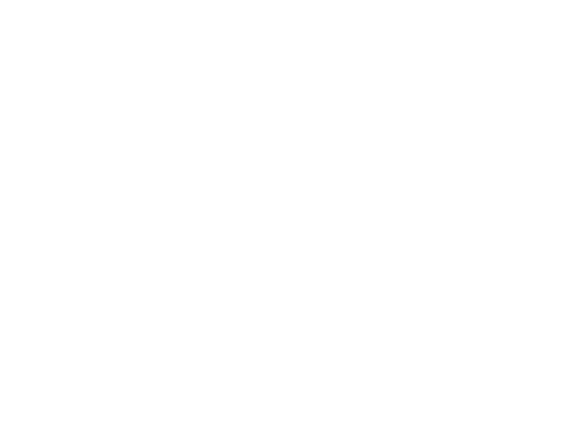

In [16]:
# Add transfers to start levels
SR_levels_time = start_level
for epoch in time_list:
    if epoch == 1:
        SR_levels_time[epoch] = SR_levels_time['Start Level (ML)'] + SR_diffs[epoch]
    else:
        SR_levels_time[epoch] = SR_levels_time[epoch - 1] + SR_diffs[epoch]

# print(SR_levels_time)
import matplotlib.pyplot as plt

%matplotlib notebook
SR_levels_time.T.plot()
plt.gca().get_legend().remove()
plt.show()

In [17]:
# test = SR_levels_time.reset_index()
# test[test['Reservoirs'] == 'HorstedKeynesReservoir'].values[0][1:].tolist()

In [18]:
def water_level_plot(timeperiods, dataframe, SR):
    #plot SR water level
    trace1 = go.Scatter(
        x = timeperiods.tolist(),
        name = SR,
        y = dataframe.loc[SR,:].tolist(),
        line = dict(
            color = ('rgb(22, 96, 167)'))
            # width = 4,
    )
    #plot backgound water level
    trace2 = go.Scatter(
        x=timeperiods.tolist(),
        y=[softmax_level.loc[SR].values[0]] * len(time_list),
        name='Max Level',
        line = dict(
            color = 'red',
            # width = 4,
            dash = 'dot')
    )
    #plot min water level
    trace3 = go.Scatter(
        x=timeperiods.tolist(),
        y=[softlow_level.loc[SR].values[0]] * len(time_list),
        name='Min water level',
        line = dict(
            color = 'red',
            # width = 4,
            dash = 'dot')
    )
    return [trace1, trace2, trace3]

for sr in reservoirs:
    data = water_level_plot(time_list, SR_levels_time, sr)
    layout = dict(title = sr,
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Water Level / ML'),
              )

    # x = list()
    # for i, source_name in enumerate(water_levels.columns):
    #     fig.append_trace(data.get(source_name), i+1, 1)

#     fig['layout'].update(height=1200, width=600, title='Stacked subplots')
    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='styled-line')

In [19]:
#Save Outputs

# Save SR_levels_time
outname = 'SR_levels_time.csv'
outdir = './Outputs'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)    
SR_levels_time.to_csv(fullname)

# Save Transfers Data Frame
outname = 'all_transfers.csv'
outdir = './Outputs'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)    
transfer_df.to_csv(fullname)

# Save Transfers IN ONLY Data Frame
outname = 'transfers_IN_ONLY.csv'
outdir = './Outputs'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)    
transfers_in_df.to_csv(fullname)

# Save Transfers OUT ONLY Data Frame
outname = 'transfers_OUT_ONLY.csv'
outdir = './Outputs'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)    
transfers_out_df.to_csv(fullname)

# Save Demand Profile Data Frame (FOR PLOTTING)
outname = 'demand_for_plot.csv'
outdir = './Outputs'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)    
demand_df.to_csv(fullname)


In [20]:
def transfer_plot(timeperiods, in_transfer, out_transfer, demand, SR):
    #plot transfers IN
    trace1 = go.Scatter(
        x = timeperiods.tolist(),
        name = 'Transfers In',
        y = in_transfer.loc[SR,:].tolist(),
        line = dict(
            color = 'cyan')
            # width = 4,
    )
    #plot transfers OUT
    trace2 = go.Scatter(
        x = timeperiods.tolist(),
        y = out_transfer.loc[SR,:].tolist(),
        name = 'Transfers Out',
        line = dict(
            color = 'green')
    )
    #plot demand
    trace3 = go.Scatter(
        x=timeperiods.tolist(),
        y=demand.loc[SR,:].tolist(),
        name='Demand',
        line = dict(
            color = 'red')
    )
    return [trace1, trace2, trace3]

for sr in reservoirs:
    data = transfer_plot(time_list, transfers_in_df, transfers_out_df, demand_df, sr)   
    layout = dict(title = sr,
              xaxis = dict(title = 'Time / Hour'),
              yaxis = dict(title = 'Water Level / ML'),
              )

    # x = list()
    # for i, source_name in enumerate(water_levels.columns):
    #     fig.append_trace(data.get(source_name), i+1, 1)

    # fig['layout'].update(height=1200, width=600, title='Stacked subplots')
    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='transfer_demand')
